# **Show that when you remove a latent space, the slack will pick it up**

In this notebook, we train a restricted version of BuDDI -- excluding the drug latent space. This is done to show that the slack space can be used to identify confounders in the data that were not directly accounted for in the modeling.


The data we use is the Kang data. We augment this dataset by modifying the stimulated cells. We only use stimulated monocytes in order to show the specificity in which BuDDI can work. Since the ground truth stimulation provides a global shift in expression, using only one cell type as the perturbed observation shows that BuDDI can truely identify a cell-type specific perturbation.


# **Imports**

In [5]:
# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
from scipy.stats import rankdata
from sklearn.metrics import average_precision_score, f1_score


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [6]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_kang/"
cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/" +
                        "CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt")

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job18_Results.csv"

# bp results
bp_res_path = f"{os.getcwd()}/../results/single_cell_data/bp_kang/"

# DiffExp results
de_res_path = f"{os.getcwd()}/../data/single_cell_data/kang_rybakov/kang_DE_paper.tsv"

num_genes = 7000

exp_id = "mono-kang"

RETRAIN_MODELS = False

# Set-up experimental variables

In [7]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8


# number of patients/domains/samples expected
n_tot_samples = 8 # 8 bulk and single cell samples

# BuDDI will use NO DRUGS in training
# we are showing we can still pick up the cell-type specific 
# expression in the slack
# we only keep this for plotting/analysis
# NOT TRAINING
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [8]:
# read in the labeled data
X_full, Y_full, gene_df, meta_df = sc_preprocess.read_all_kang_pseudobulk_files(aug_data_path, exp_id, num_bulks_training=10)
X_full.columns = gene_df


1488
STIM
Train
Test
CTRL
Train
Test
1244
STIM
Train
Test
CTRL
Train
Test
1016
STIM
Train
Test
CTRL
Train
Test
101
STIM
Train
Test
CTRL
Train
Test
1039
STIM
Train
Test
CTRL
Train
Test
107
STIM
Train
Test
CTRL
Train
Test


# Define indices and set-up metadata

In [9]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "kang_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train_df = X_train_df[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6928)[-6928:]
gene_df = gene_df.iloc[idx_top]


# compare our variable genes with cibersort defined genes

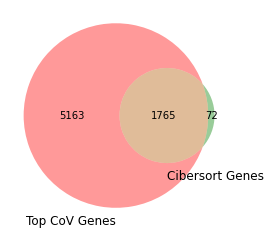

In [10]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [11]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

# Normalize data

In [12]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


# Plot all data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 17320 samples in 0.115s...
[t-SNE] Computed neighbors for 17320 samples in 27.511s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17320
[t-SNE] Computed conditional probabilities for sample 2000 / 17320
[t-SNE] Computed conditional probabilities for sample 3000 / 17320
[t-SNE] Computed conditional probabilities for sample 4000 / 17320
[t-SNE] Computed conditional probabilities for sample 5000 / 17320
[t-SNE] Computed conditional probabilities for sample 6000 / 17320
[t-SNE] Computed conditional probabilities for sample 7000 / 17320
[t-SNE] Computed conditional probabilities for sample 8000 / 17320
[t-SNE] Computed conditional probabilities for sample 9000 / 17320
[t-SNE] Computed conditional probabilities for sample 10000 / 17320
[t-SNE] Computed conditional probabilities for sample 11000 / 17320
[t-SNE] Computed conditional probabilities for sample 12000 / 17320
[t-SNE] Computed conditional probabilities for sa

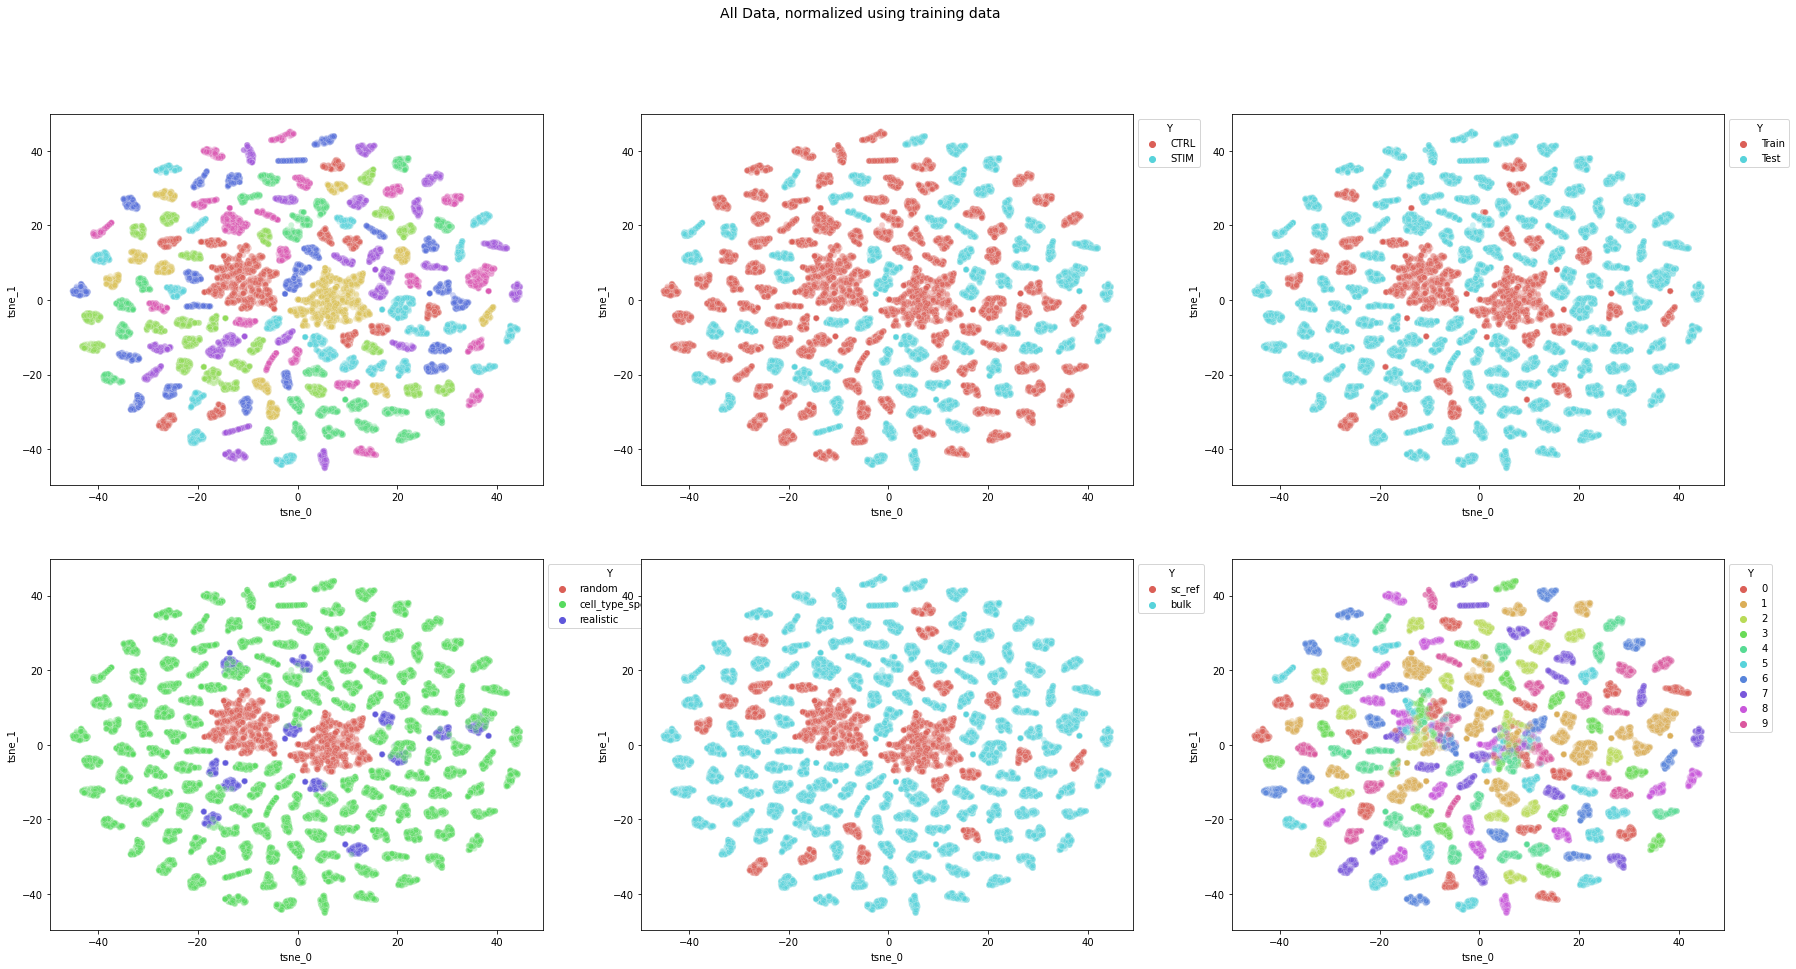

In [13]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


(120, 2)
(120, 2)


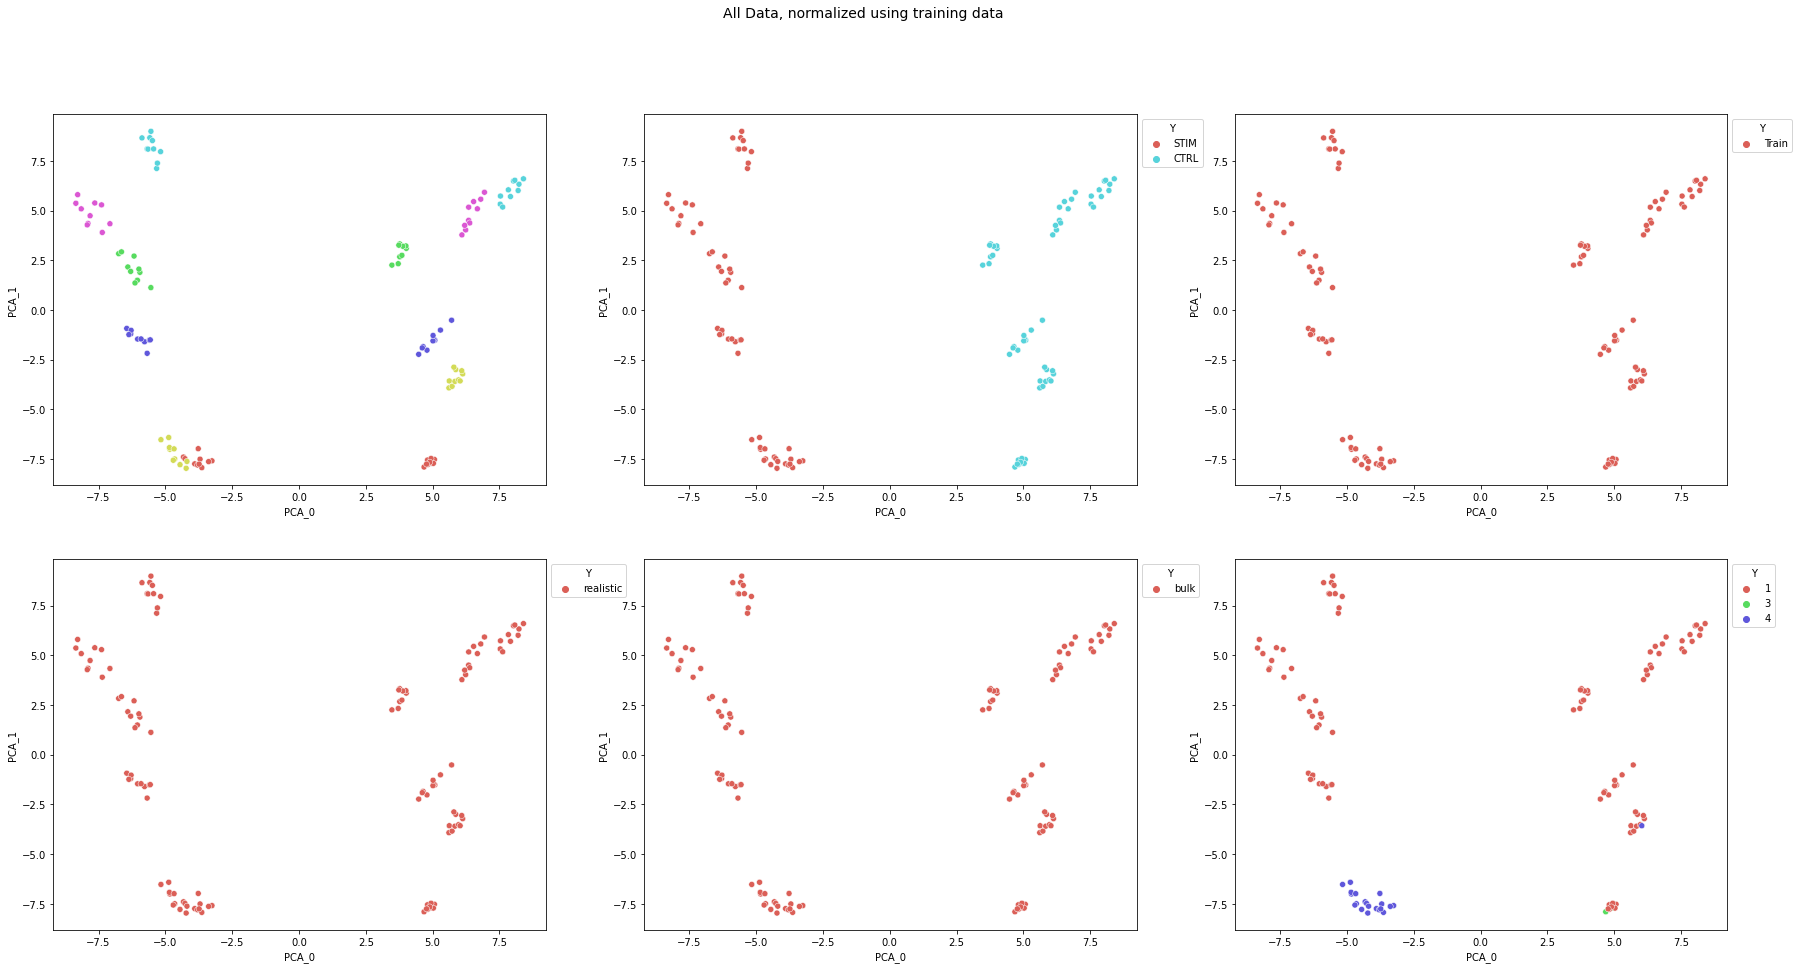

In [14]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"", alpha=1)
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"", alpha=1)


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.001s...
[t-SNE] Computed neighbors for 120 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 12.872424
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.187634
[t-SNE] KL divergence after 500 iterations: 0.067693
(120, 2)
(120, 2)


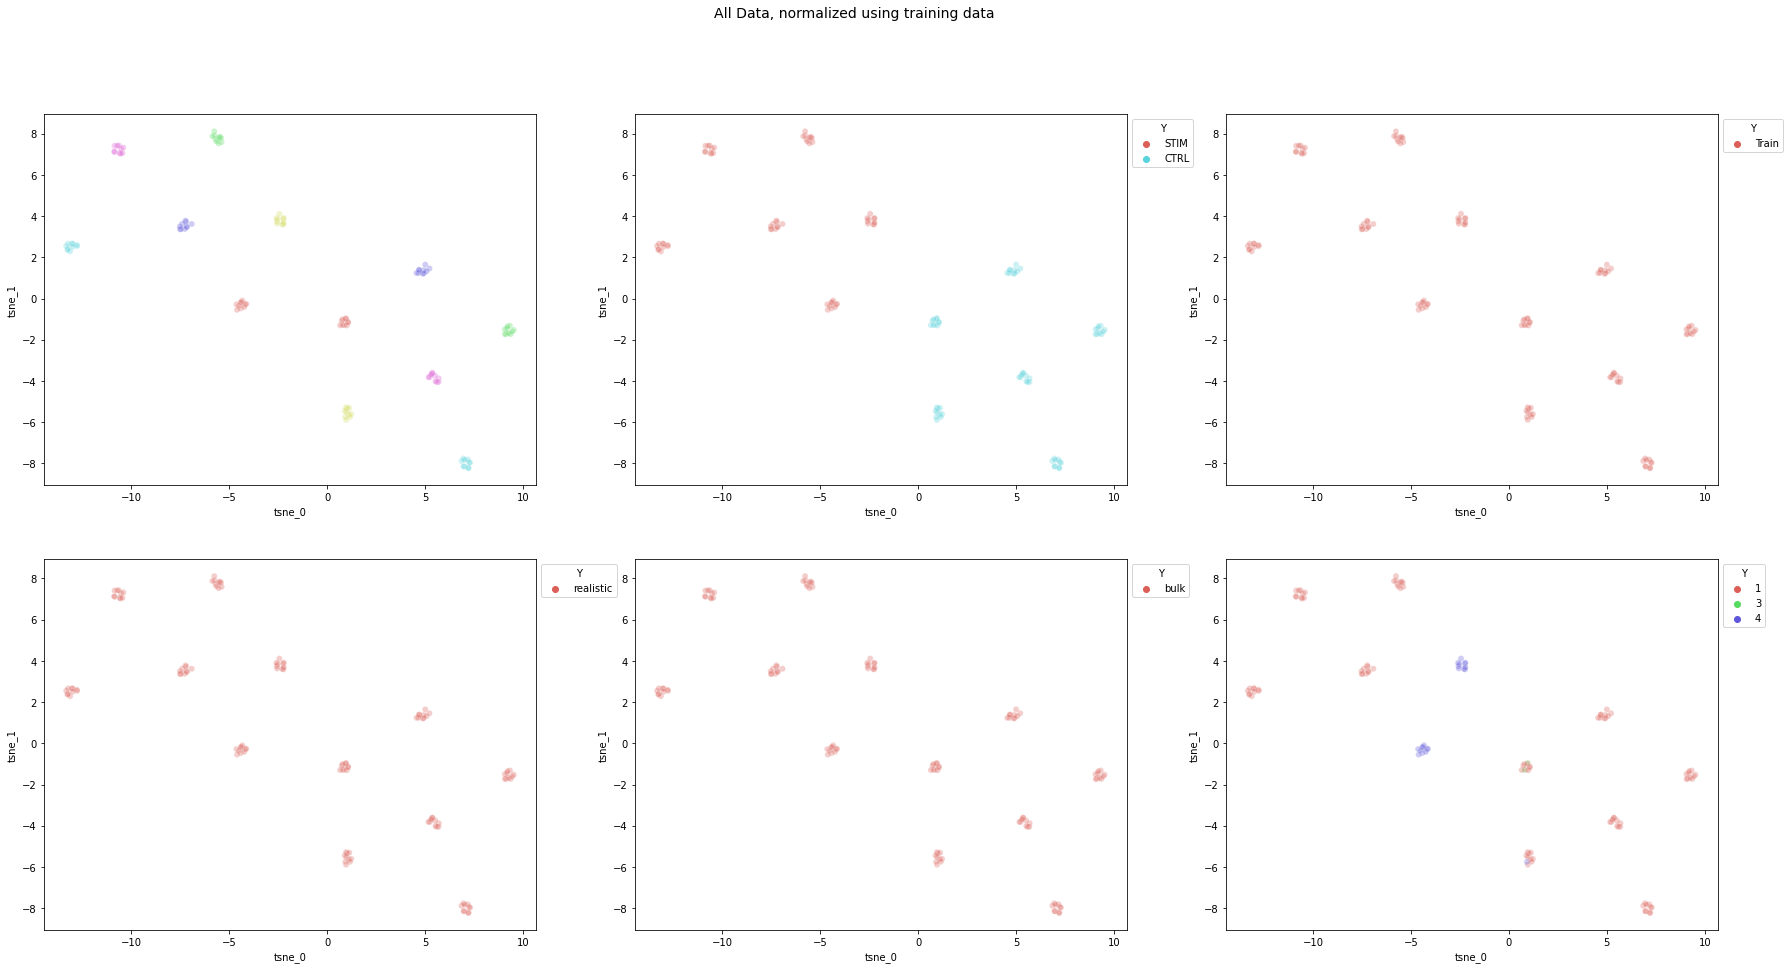

In [15]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_tsne_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Train Models**

Using the hyperparameters learned from using the full BuDDI model, train the restricted BuDDI models

In [16]:
from importlib import reload  # Python 3.4+
reload(buddi)
reload(buddi.buddi3)
reload(sc_preprocess)
reload(vp)

<module 'buddi.plotting.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../buddi/plotting/validation_plotting.py'>

In [17]:
curr_n_epoch=100
curr_wt = 1000

if True: #RETRAIN_MODELS

    params = buddi.BuddiTrainParameters(n_epoch=100, 
                alpha_rot=1000000, alpha_prop=100, 
                alpha_bulk=100, alpha_drug=10000)

    ## model 1
    curr_exp_id = f"buddi3_model1_{exp_id}"
    res1 = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=False, 
                n_tot_samples=n_tot_samples, n_drugs=0, n_tech=n_tech, 
                X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=None, bulk_unkp=bulk_unkp,
                X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=None, bulk_kp=bulk_kp, params=params)

    ## model 2
    curr_exp_id = f"buddi3_model2_{exp_id}"
    res2 = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=False, 
                n_tot_samples=n_tot_samples, n_drugs=0, n_tech=n_tech, 
                X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=None, bulk_unkp=bulk_unkp,
                X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=None, bulk_kp=bulk_kp, params=params)

    ## model 3
    curr_exp_id = f"buddi3_model3_{exp_id}"
    res3 = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=False, 
                n_tot_samples=n_tot_samples, n_drugs=0, n_tech=n_tech, 
                X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=None, bulk_unkp=bulk_unkp,
                X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=None, bulk_kp=bulk_kp, params=params)


res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/buddi3_model3_{exp_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/buddi3_model3_{exp_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/buddi3_model3_{exp_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/buddi3_model3_{exp_id}_classifier")


test_size_samp: 500
train_size_samp: 3500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## Plot Latent Spaces

In [ ]:

def plot_slack(encoder_unlab, encoder_unlab_b4,
        X_temp, Y_temp, perturb_temp, 
        batch_size):

    z_slack, mu_slack, _, z_rot, mu_rot, _, z_bulk, mu_bulk, _ = encoder_unlab.predict(X_temp, batch_size=batch_size)
    _, mu_slack_b4, _, _, _, _, _, _, _, _, _, _ = encoder_unlab_b4.predict(X_temp, batch_size=batch_size)



    fig, axs = plt.subplots(1, 2, figsize=(20,10))

    # format
    perturb_temp_str = ["Yes" if x else "No" for x in perturb_temp]
    

    # get cumsums
    from sklearn.decomposition import PCA

    fit = PCA(n_components=20)
    pca_results = fit.fit_transform(np.asarray(mu_slack))
    exp_var_pca = fit.explained_variance_ratio_

    pca_results = fit.fit_transform(np.asarray(mu_slack_b4))
    exp_var_pca_b4 = fit.explained_variance_ratio_



    # plot
    plot_df = vp.get_pca_for_plotting(np.asarray(mu_slack))
    vp.plot_pca(plot_df, color_vec=perturb_temp_str, ax=axs[0], 
                title="Slack space from BuDDI without adding a perturbation latent space", alpha=1, legend_title="Perturbed")
    
    plot_df = vp.get_pca_for_plotting(np.asarray(mu_slack_b4))
    vp.plot_pca(plot_df, color_vec=perturb_temp_str, ax=axs[1], 
                title="Slack space from BuDDI with a perturbation latent space", alpha=1, legend_title="Perturbed")

    axs[0].set_xlabel(f"PCA 0 (Var. Exp.: {exp_var_pca[0]:.2f})")
    axs[0].set_ylabel(f"PCA 1 (Var. Exp.: {exp_var_pca[1]:.2f})")


    axs[1].set_xlabel(f"PCA 0 (Var. Exp.: {exp_var_pca_b4[0]:.2f})")
    axs[1].set_ylabel(f"PCA 1 (Var. Exp.: {exp_var_pca_b4[1]:.2f})")


    return fig

def plot_celltype_pert(encoder_unlab, curr_cell_types,
        X_temp, Y_temp, perturb_temp, label_temp,
        batch_size):

    z_slack, mu_slack, _, z_rot, mu_rot, _, z_bulk, mu_bulk, _ = encoder_unlab.predict(X_temp, batch_size=batch_size)

    fig, axs = plt.subplots(2, len(curr_cell_types), figsize=(30,15))
    plot_idx = 0
    for curr_cell in curr_cell_types:

        # only get the info from one cell type at a time
        idx_cell_type = np.where(Y_temp == curr_cell)[0]
        curr_mu_slack = mu_slack[idx_cell_type]
        curr_perturb_temp = perturb_temp[idx_cell_type]
        curr_label_temp = label_temp[idx_cell_type]


        # format
        curr_perturb_temp_str = ["Yes" if x  else "No" for x in curr_perturb_temp ]

        # continue if missing
        if len(idx_cell_type) == 0:
            continue

        # plot
        plot_df = vp.get_pca_for_plotting(np.asarray(curr_mu_slack))
        vp.plot_pca(plot_df, color_vec=curr_perturb_temp_str, ax=axs[0,plot_idx], title=curr_cell, alpha=1, legend_title="Perturbed")
        vp.plot_pca(plot_df, color_vec=curr_label_temp, ax=axs[1,plot_idx], title="", alpha=1, legend_title="Sample IDs")

        
        plot_idx = plot_idx +1


    fig.show()


    return fig


### plot data

(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)


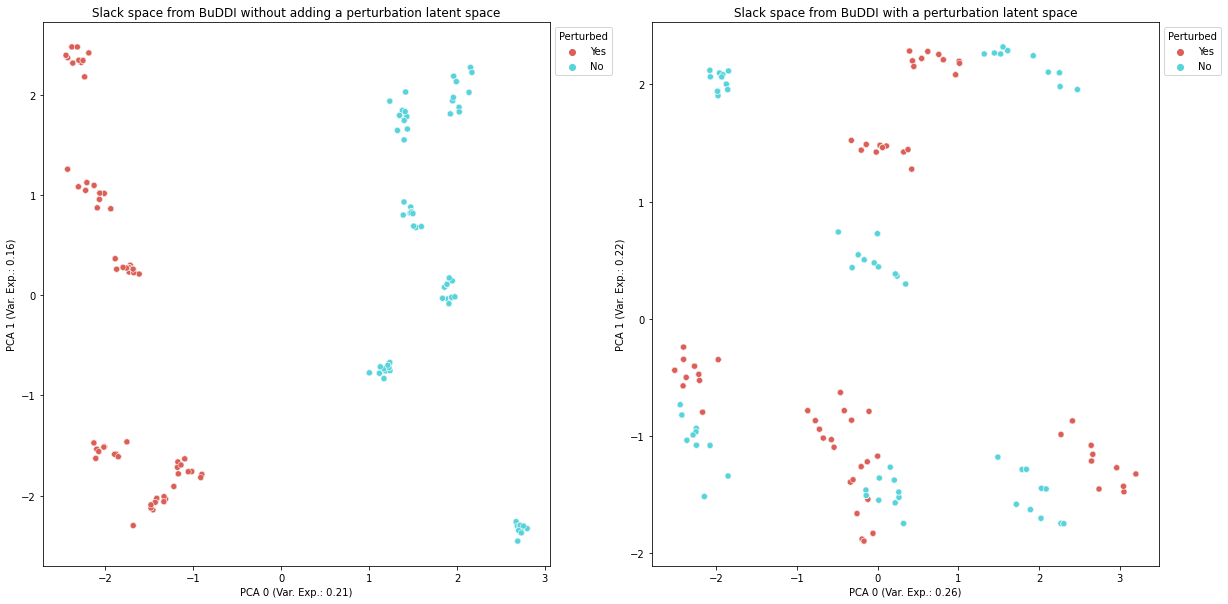

In [ ]:
# plot stim and ctrl bulks used in training
idx_tmp = np.logical_and(meta_df.isTraining == "Train", meta_df.samp_type == "bulk")
idx_tmp_stim = np.where(np.logical_and(idx_tmp, meta_df.stim == "STIM"))[0]
idx_tmp_ctrl = np.where(np.logical_and(idx_tmp, meta_df.stim == "CTRL"))[0]
idx_tmp_stim = np.random.choice(idx_tmp_stim, 500, replace=True)
idx_tmp_ctrl = np.random.choice(idx_tmp_ctrl, 500, replace=True)


idx_tmp = np.append(idx_tmp_stim, idx_tmp_ctrl)
idx_tmp.shape

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


prop_outputs = res1_classifier.predict(X_temp, batch_size=500)
Y_pert = np.copy(prop_outputs)
Y_pert = np.argmax(Y_pert, axis=1)
Y_temp = Y_full.columns[Y_pert]

true_prop_df = Y_full.iloc[idx_tmp]


label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]


res1_latent_plot = plot_slack(res1_enc_unlab, res1_enc_unlab_b4, 
                        X_temp, Y_temp, perturb_temp, 
                        batch_size=500)

(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)


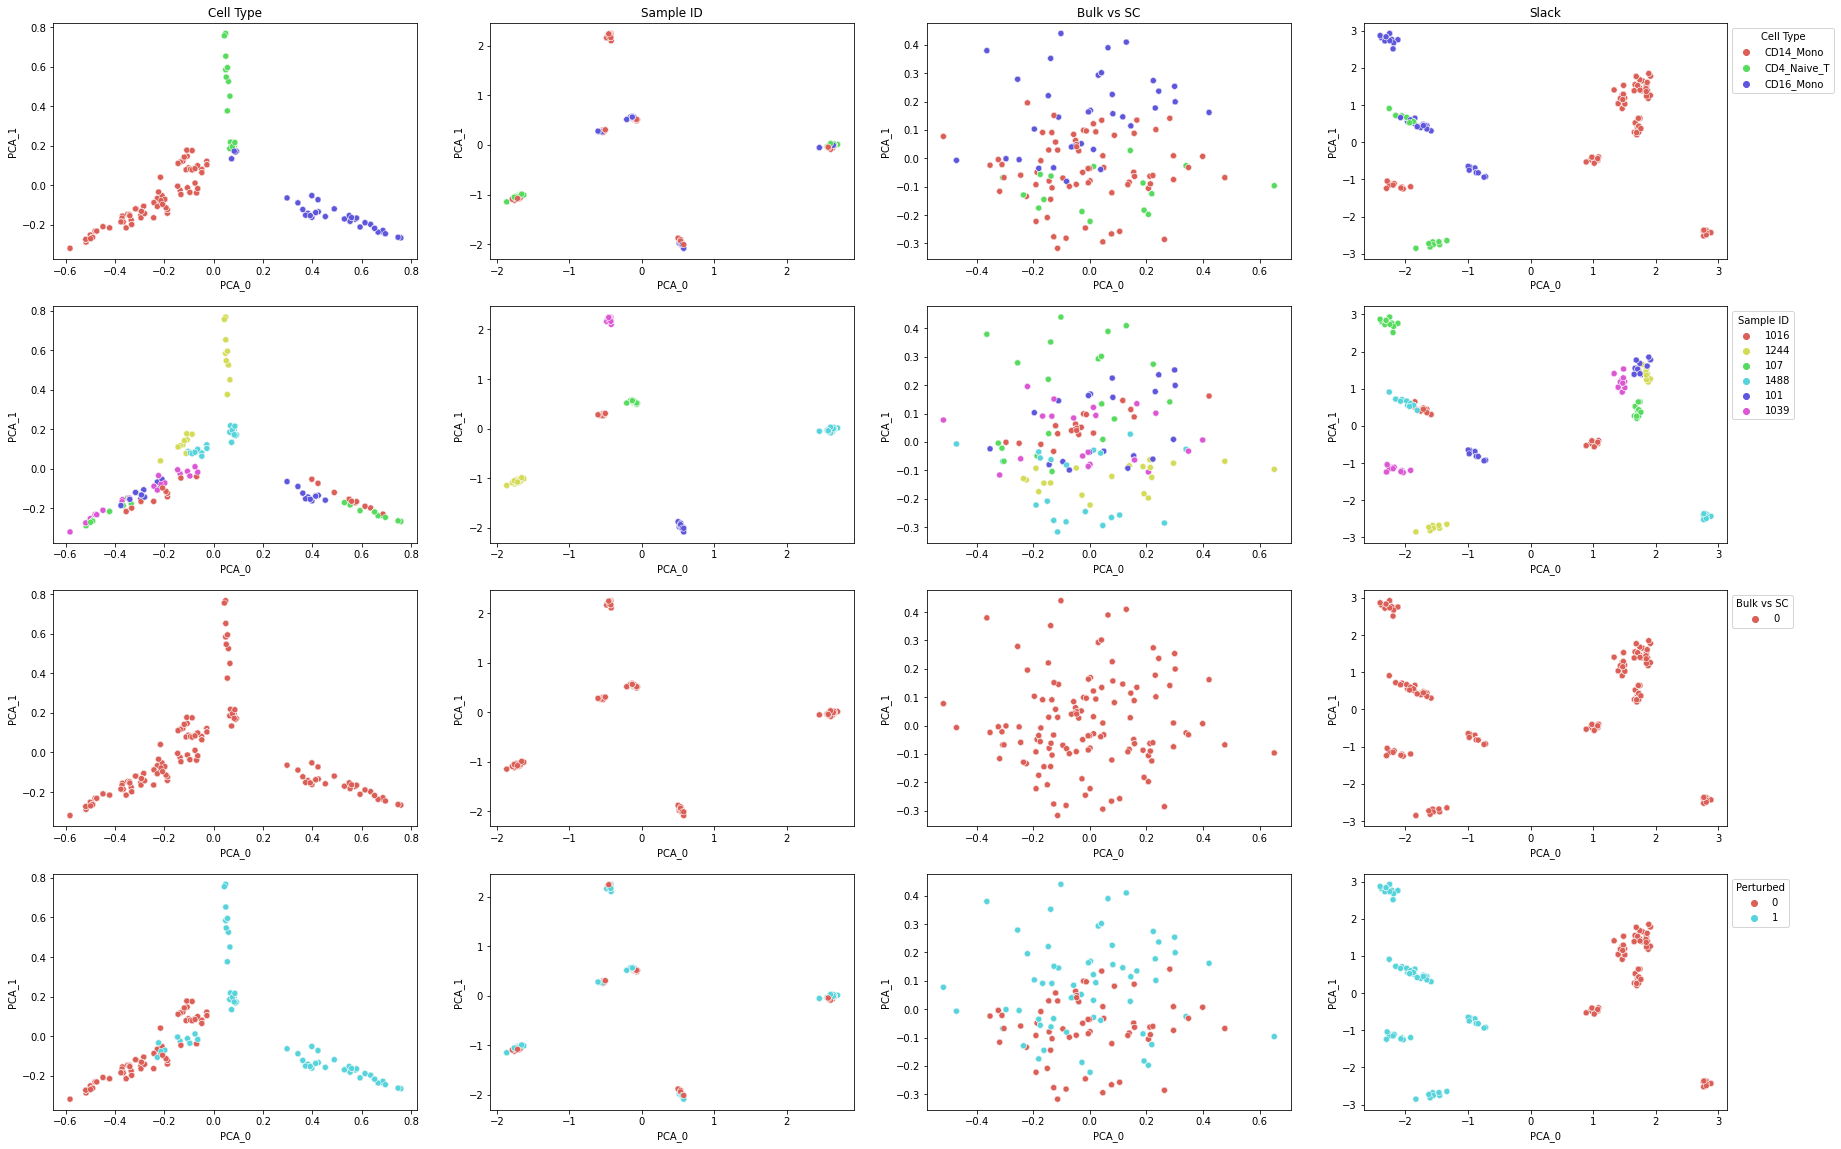

In [ ]:
# now plot with predicted cell type labels
# cell type proportion labels
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.samp_type == "bulk"))[0]
idx_tmp = np.random.choice(idx_tmp, 1000, replace=True)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

# make predictions
prop_outputs = res1_classifier.predict(X_temp, batch_size=500)
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]


res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp, bulk_temp, 
                        batch_size=500, use_buddi4=False)

(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)


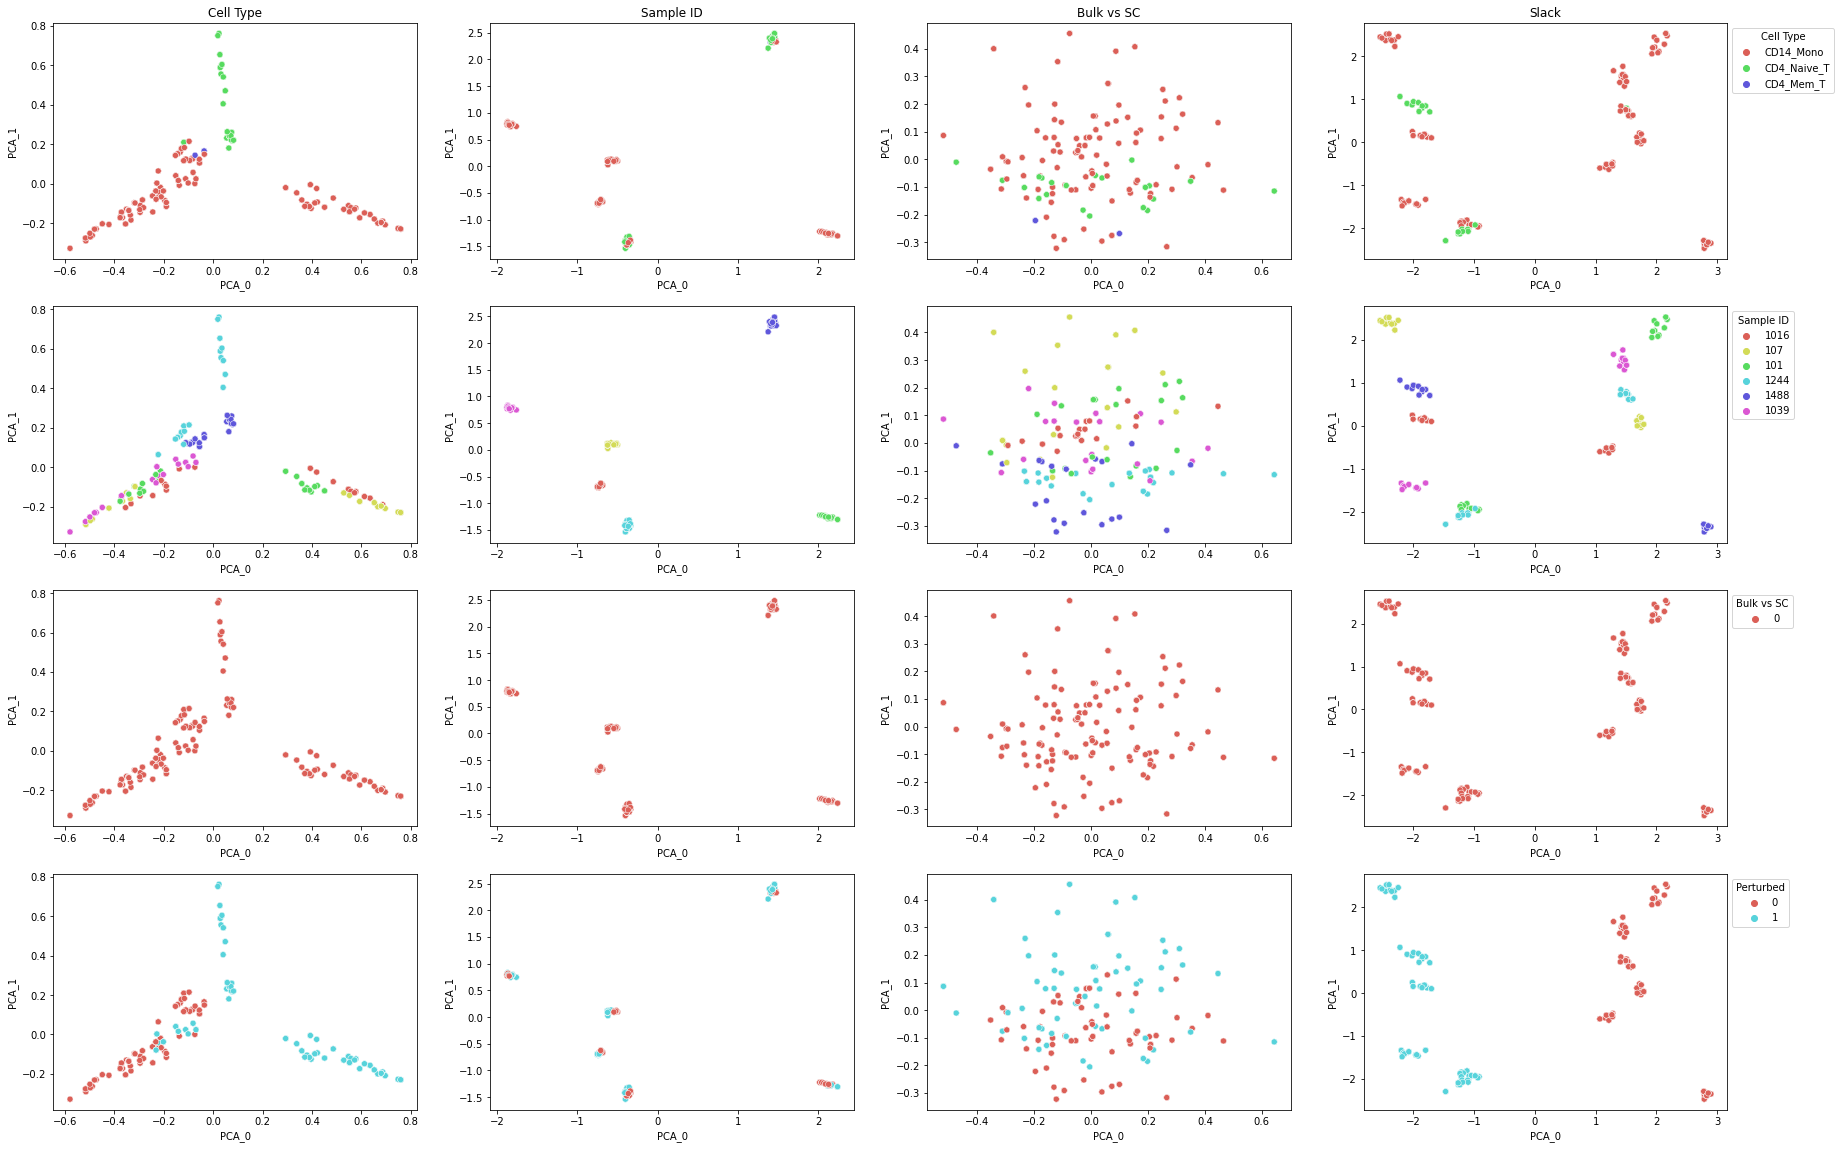

In [ ]:
# now plot with ground truth
# cell type proportion labels
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.samp_type == "bulk"))[0]
idx_tmp = np.random.choice(idx_tmp, 1000, replace=True)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]


res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp, bulk_temp, 
                        batch_size=500, use_buddi4=False)